In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# One-Dimensional Climate Models: The Basics of Planets

In this tutorial you will learn the very basics of running 1D climate runs. For a more in depth look at the climate code check out [Mukherjee et al. 2022](https://arxiv.org/abs/2208.07836) (note this should also be cited if using this code/tutorial). 

What you should already be familiar with: 

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)

What you will need to download to use this tutorial: 

1. [Download](https://zenodo.org/record/5590989#.Yzy2YOzMI8a) 196 Correlated-K Tables from Roxana Lupu to be used by the climate code for opacity 
2. [Download](https://zenodo.org/record/5063476/files/structures_m%2B0.0.tar.gz?download=1) the sonora bobcat cloud free `structures_` file so that you can validate your model run 

**Note**: the two files above are dependent on metallicity and C/O. For this tutorial we will stick to solar M/H and solar C/O, but note that you can change that in the future. 

In [2]:
#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

#ck_db = f'/Users/nbatalh1/Documents/data/kcoeff_2020/sonora_2020_feh{mh}_co_{CtoO}.data.196'
ck_db = f'/Users/sagnickmukherjee/Documents/GitHub/Disequilibrium-Picaso/reference/climate_INPUTS/sonora_2020_feh+1.0_co_1.0.data.196'
#sonora bobcat cloud free structures file
sonora_profile_db = '/Users/nbatalh1/Documents/data/sonora_bobcat/structures_m+0.0/'


## What does a climate model solve for?

1D Radiative-Convective Equilibrium Models solve for atmospheric structures of brown dwarfs and exoplanets, which includes:

1\. The Temperature Structure (T(P) profile)
 
2\. The Chemical Structure 

3\. Energy Transport in the atmosphere

4\. Clouds 

But these physical components are not independent of each other. For example, the chemistry is dependent on the T(P) profile, the radiative transfer is dependent on clouds and the chemistry and so on. 

`PICASO` tries to find the atmospheric state of your object by taking care of all of these processes and their interconnections self-consistently and iteratively. Therefore, you will find that the climate portion of `PICASO` is slower than running a single forward model evaluation. 

## Starting up the Run

You will notice that starting a run is nearly identical as running a spectrum. However, how we will add `climate=True` to our inputs flag. We will also specify `browndwarf` in this case, which will turn off the irradiation the object is receiving. 

New Parameter: **Effective Temperature**. This excerpt from [Modeling Exoplanetary Atmospheres (Fortney et al)](https://arxiv.org/pdf/1804.08149.pdf) provides a thorough description and more reading, if you are interested.

> If the effective temperature, $T_{eff}$, is defined as the temperature of a blackbody of
the same radius that would emit the equivalent flux as the real planet, $T_{eff}$ and $T_{eq}$
can be simply related. This relation requires the inclusion of a third temperature,
$T_{int}$, the intrinsic effective temperature, that describes the flux from the planet’s
interior. These temperatures are related by:
$$T_{eff} =  T_{int} + T_{eq}$$
> We then recover our limiting cases: if a planet is self-luminous (like a young giant
planet) and far from its parent star, $T_{eff} \approx  T_{int}$; for most rocky planets, or any
planets under extreme stellar irradiation, $T_{eff} \approx T_{eq}$.

In [3]:
cl_run = jdi.inputs(calculation="planet", climate = True) # start a calculation 

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation  


tint= 200 # Intrinsic Temperature of your Planet in K
grav = 4.5 # Gravity of your Planet in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature

Let's now grab our gaseous opacities, whose path we have already defined above. Again, this code uses a correlated-k approach for accurately capturing opacities (see [section 2.1.4; Mukerjee et al 2022](https://arxiv.org/pdf/2208.07836.pdf)).

In [4]:
# Notice The keyword ck is set to True because you want to use the correlated-k opacities for your calculation
# and not the line by line opacities
opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

Let's now input the host-star properties

In [5]:
T_star =5326.6 # K, star effective temperature
logg =4.38933 #logg , cgs
metal =-0.03 # metallicity of star
r_star = 0.932 # solar radius
semi_major = 0.0486 # star planet distance, AU

cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star, radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)#opacity db, pysynphot database, temp, metallicity, logg


## Initial T(P)  Guess

Every calculation requires an initial guess of the pressure temperature profile. The code will iterate from there to find the correct solution. A few tips: 

1. We recommend **using typically 51-91 atmospheric pressure levels**. Too many pressure layers increases the computational time required for convergence. Too little layers makes the atmospheric grid too coarse for an accurate calculation.

2. Start with **a guess that is close to your expected solution**. We will show an example using an isothermal P(T) profile below so you can see the iterative process. Later though, we recommend leveraging pre-computed grids (e.g. Sonora) as a starting guess. 


In [6]:
nlevel = 91 # number of plane-parallel levels in your code

#Lets set the max and min at 1e-4 bars and 500 bars

#Pmin = 1e-6 #bars
#Pmax = 100 #bars
#pressure=np.logspace(np.log10(Pmin),np.log10(Pmax),nlevel) # set your pressure grid


path = "/Users/sagnickmukherjee/Documents/research/geers/wasp39b"
file_path= path+"/tpfile/tp_eq_planet_200_grav_4.5_mh_+1.0_CO_1.0_sm_0.0486_v_0.5_.dat"
pressure,temp_guess = np.loadtxt(file_path,usecols=[0,1],unpack=True)

#temp_guess = np.zeros(shape=(nlevel)) + 1000 # K , isothermal atmosphere guess

## Initial Convective Zone Guess

You also need to have a crude guess of the convective zone of your atmosphere. Generally the deeper atmosphere is always convective. Again a good guess is always the published SONORA grid of models for this. But lets assume that the bottom 7 levels of the atmosphere is convective. 

**New Parameters:**

1. `nofczns` : Number of convective zones. Though the code has functionality to solve for more than one. In this basic tutorial, let's stick to 1 for now.
2. `rfacv`: (See Mukherjee et al Eqn. 20 `r_st`) https://arxiv.org/pdf/2208.07836.pdf

Non-zero values of rst (aka "rfacv" legacy terminology) is only relevant when the external irradiation on the atmosphere is non-zero. In the scenario when a user is computing a planet-wide average T(P) profile, the stellar irradiation is contributing to 50% (one hemisphere) of the planet and as a result rst = 0.5. If instead the goal is to compute a night-side average atmospheric state, rst is set to be 0. On the other extreme, to compute the day-side atmospheric state of a tidally locked planet rst should be set at 1.

In [7]:
nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr_upper = 85 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.5 #we are focused on a brown dwarf so let's keep this as is

Now we would use the inputs_climate function to input everything together to our cl_run we started.

In [8]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure, 
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)

## Run the Climate Code

 The actual climate code can be run with the cl_run.run command. The save_all_profiles is set to True to save the T(P) profile at all steps. The code will now iterate from your guess to reach the correct atmospheric solution for your brown dwarf of interest.
 
 

In [9]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Iteration number  0 , min , max temp  807.72631645267 3428.943220778174 , flux balance  30.325674368740728
Iteration number  1 , min , max temp  815.2441482862206 4677.401102559242 , flux balance  0.7590839255871659
Iteration number  2 , min , max temp  815.137589352594 4338.760394268968 , flux balance  0.0008271244357388644
Iteration number  3 , min , max temp  815.1375425436665 4317.896655192397 , flux balance  2.9947494168098516e-07
Iteration number  4 , min , max temp  815.1375425349145 4317.804978636265 , flux balance  9.105070876053391e-11
In t_start: Converged Solution in iterations  4
Big iteration is  815.1375425349145 0
Iteration number  0 , min , max temp  815.3739604949111 4657.025056568878 , flux balance  2.5039515787067272
Iteration number  1 , min , max temp  816.3340806476107 5199.9 , flux balance  0.02081037496500183
Iteration number  2 , min , max temp  816.3319353986443 5199.9 , flux balance  4.925942516202113e-06
Iteration number  3 , min , max temp  816.33193492993

Text(0.5, 1.0, 'T$_{\\rm eff}$= 1000 K, log(g)=5.0')

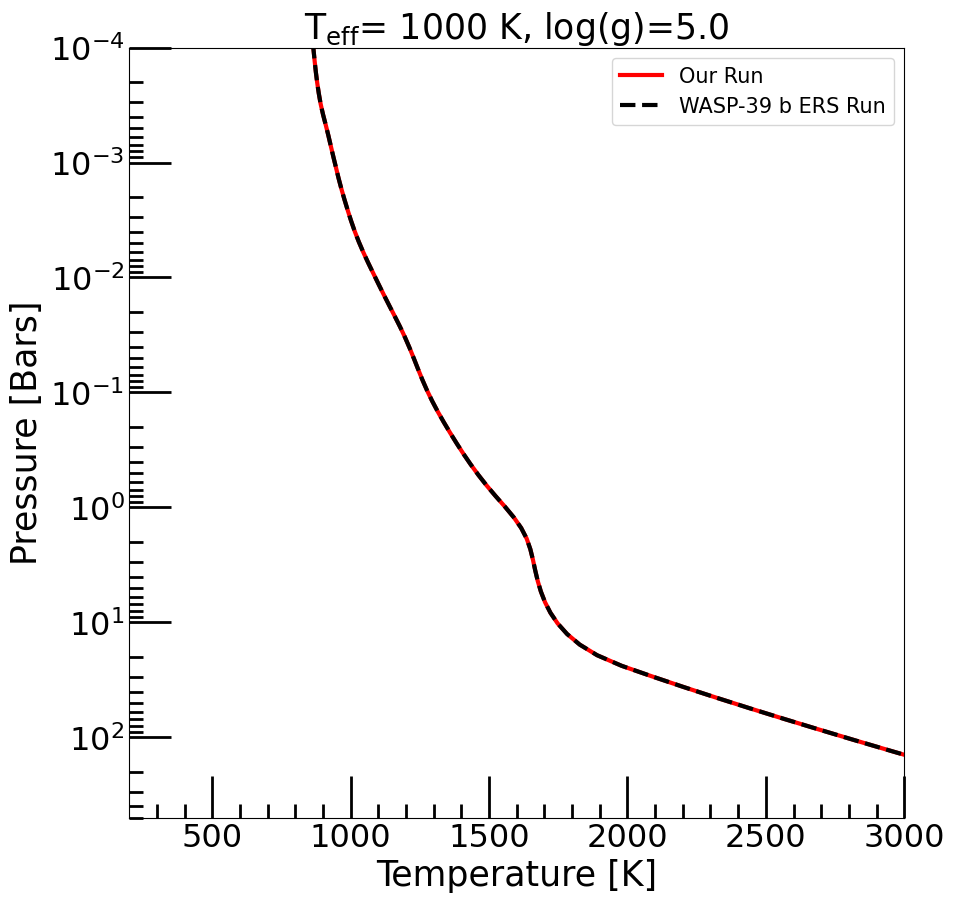

In [13]:
plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(500,1e-4)
plt.xlim(200,3000)

plt.semilogy(out['temperature'],out['pressure'],color="r",linewidth=3,label="Our Run")

plt.semilogy(temp_guess,pressure,color="k",linestyle="--",linewidth=3,label="WASP-39 b ERS Run")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 1000 K, log(g)=5.0",fontsize=25)



### Brightness Temperature

Checking the brightness temperature serves many useful purposes: 

1. Intuition building. Allows you to see what corresponding temperature are you sensitive to at each wavelength 

Note that this temperature doesn't need to be the physical temperature of your atmosphere but if you can find the physical converged atmospheric temperature closest to this brightness temperature you can also get an idea of the atmospheric pressure from where the flux you are seeing is originating from.

2. Determining if your choice in bottom boundary pressure grid was correct. 

If your brightness temperature is such that you bottom out at the temperature corresponding to the highest pressure, you have not extended your grid to high enough pressures. 

Brightness Temperature Equation:

$T_{\rm bright}=\dfrac{a}{{\lambda}log\left(\dfrac{{b}}{F(\lambda){\lambda}^5}+1\right)}$

where a = 1.43877735$\times$10$^{-2}$ m.K and b = 11.91042952$\times$10$^{-17}$ m$^4$kg/s$^3$ 

Let's calculate the brigthness temperature of our current run and check if our pressure grid was okay.

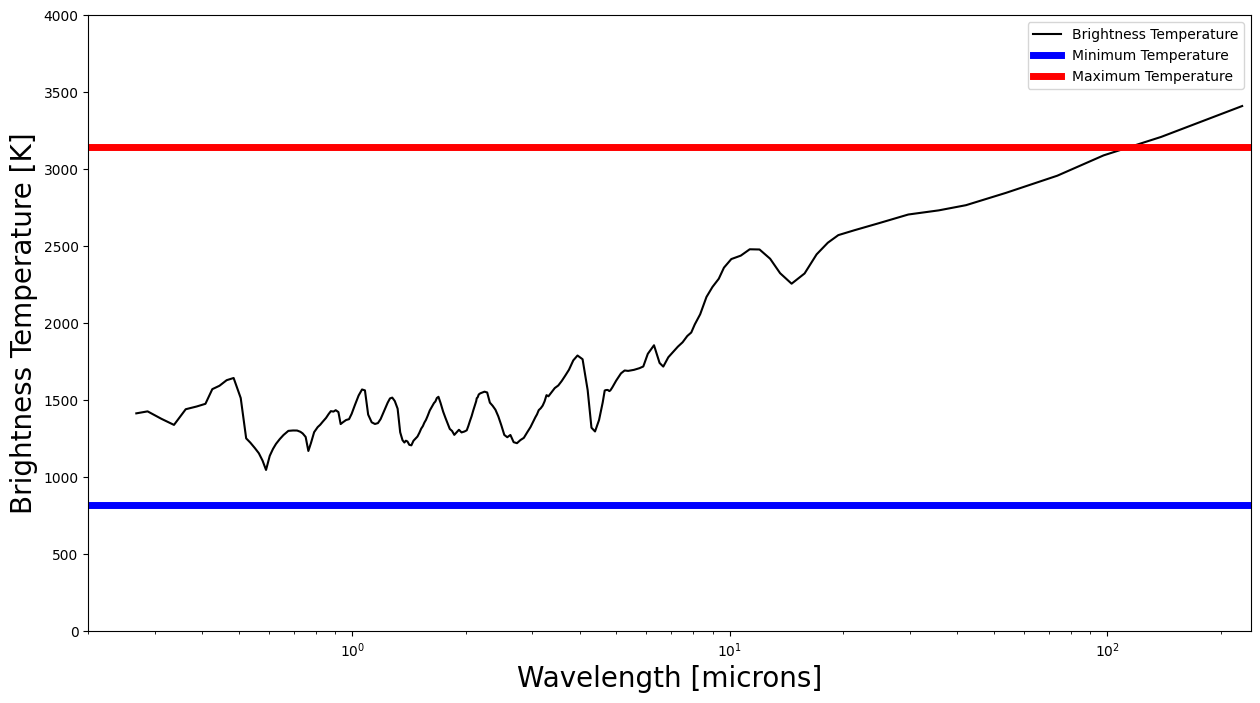

In [12]:
brightness_temp, figure= jpi.brightness_temperature(out['spectrum_output'])